In [101]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from scipy.ndimage import generate_binary_structure, label
from scipy.ndimage import sum as ndimage_sum

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder

#f_name = "./ref_FS001_121011_1_J.fits"
#f_name = "./ref_FS014_151219_1_J.fits"
f_name = "./ref_FS017_120106_1_J.fits"

# satelita

def add_satellite(img, length=50, width=3, flux=10000, sigma=2.0):
    nx,ny = img.shape
    x0 = np.random.randint(0, nx)
    y0 = np.random.randint(0, ny)
    angle = np.random.uniform(0, np.pi)

    x = np.arange(nx)
    y = np.arange(ny)
    Y, X = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

    # Linie proste w kierunku angle
    dx = np.cos(angle)
    dy = np.sin(angle)

    # Wyznacz odległość punktów od linii satelity
    dist = ( (X - x0)*dy - (Y - y0)*dx )  # równoległe
    along = ( (X - x0)*dx + (Y - y0)*dy )  # wzdłuż

    # maska: pas o długości `length`, szerokości `width`
    mask = (np.abs(dist) < width) & (np.abs(along) < length / 2)

    temp = np.zeros_like(img, dtype=float)
    temp[mask] = flux

    return img + gaussian_filter(temp, sigma=sigma)


# cosmic ray

def add_cosmic_ray(img, n_segments=1, flux=30000, thickness=1):
    nx,ny = img.shape
    temp = np.zeros_like(img, dtype=float)
    x,y = np.random.randint(10, nx - 10), np.random.randint(10, ny - 10)

    for _ in range(n_segments):
        dx = np.random.randint(-5, 6)
        dy = np.random.randint(-5, 6)
        x_new = np.clip(x + dx, 0, nx - 1)
        y_new = np.clip(y + dy, 0, ny - 1)

        # Prostokąt o grubości `thickness`
        for i in range(-thickness, thickness + 1):
            for j in range(-thickness, thickness + 1):
                xi = np.clip(int(x_new + i), 0, nx - 1)
                yi = np.clip(int(y_new + j), 0, ny - 1)
                temp[yi, xi] += flux

        x, y = x_new, y_new

    return img + temp


In [102]:
hdul = fits.open(f_name)
image = hdul[0].data
header = hdul[0].header
hdul.close()


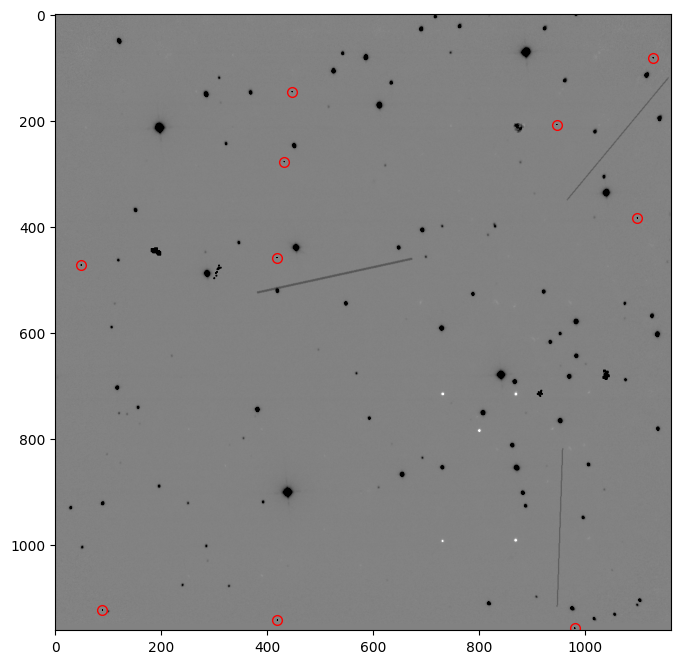

In [103]:
# dodanie hot pikseli

np.random.seed(12)

hot_piksels = Table(names=('x', 'y', 'flux'), dtype=(int, int, float))

flux = 5000
for _ in range(10):
    x = np.random.randint(0, image.shape[0])
    y = np.random.randint(0, image.shape[1])
    hot_piksels.add_row((x, y, flux))
    image[y,x] = image[y,x] + flux

# satelita

np.random.seed(1)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=1)

np.random.seed(2)
image = add_satellite(image, length=300, width=2, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=1)

np.random.seed(3)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)
image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=2)

np.random.seed(4)
image = add_cosmic_ray(image, n_segments=5, flux=1000, thickness=3)

np.random.seed(5)
image = add_cosmic_ray(image, n_segments=20, flux=100, thickness=2)

# rysowanie

x_hot = hot_piksels["x"].data
y_hot = hot_piksels["y"].data

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin+5,vmax=vmax+5,cmap='binary')
plt.plot(x_hot, y_hot, 'o', markerfacecolor='none', markeredgecolor='red', markersize=7)
plt.show()

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Eliptyczność (major/minor): 1.23
3 39
Eliptyczność (major/minor): 1.57
4 50
Eliptyczność (major/minor): 1.53
5 38
Eliptyczność (major/minor): 2.14
6 57
Eliptyczność (major/minor): 1.85
7 162
Eliptyczność (major/minor): 1.36
8 30
Eliptyczność (major/minor): 1.37
10 67
Eliptyczność (major/minor): 1.26
12 62
Eliptyczność (major/minor): 3.69
13 59
Eliptyczność (major/minor): 3.83
14 15
Eliptyczność (major/minor): 1.32
15 36
Eliptyczność (major/minor): 1.08
16 36
Eliptyczność (major/minor): 1.31
17 38
Eliptyczność (major/minor): 1.71
19 63
Eliptyczność (major/minor): 1.34
20 87
Eliptyczność (major/minor): 2.53
21 54
Eliptyczność (major/minor): 1.33
22 175
Eliptyczność (major/minor): 5.18
25 15
Eliptyczność (major/minor): 14.21
26 15
Eliptyczność (major/minor): 1.37
28 33
Eliptyczność (major/minor): 2.20
29 20
Eliptyczność (major/minor): 1.89
30 55
Eliptyczność (major/minor): 1.32
32 25
Eliptyczność (major/minor): 1.40
33 104
Eliptyczność (major/minor): 1.74
34 37
Eliptyczność (major/minor):

/var/folders/d1/n39w6bbs3f1_3tml2k1fftww0000gn/T/ipykernel_7785/3550353964.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  ellipticity = eigvals[1] / eigvals[0]  # >1 = wydłużony, ~1 = okrągły


Eliptyczność (major/minor): 22.98
103 29
Eliptyczność (major/minor): 1.30
104 27
Eliptyczność (major/minor): 1.73
105 16
Eliptyczność (major/minor): 2.57
106 12
Eliptyczność (major/minor): 2.94
107 12
Eliptyczność (major/minor): 3.78
108 8
Eliptyczność (major/minor): 15.33
109 6
Eliptyczność (major/minor): 4.36
112 31
Eliptyczność (major/minor): 1.53
113 42
Eliptyczność (major/minor): 10.14
114 7
Eliptyczność (major/minor): 1.25
116 51
Eliptyczność (major/minor): 1.91
119 23
Eliptyczność (major/minor): 1.84
120 28


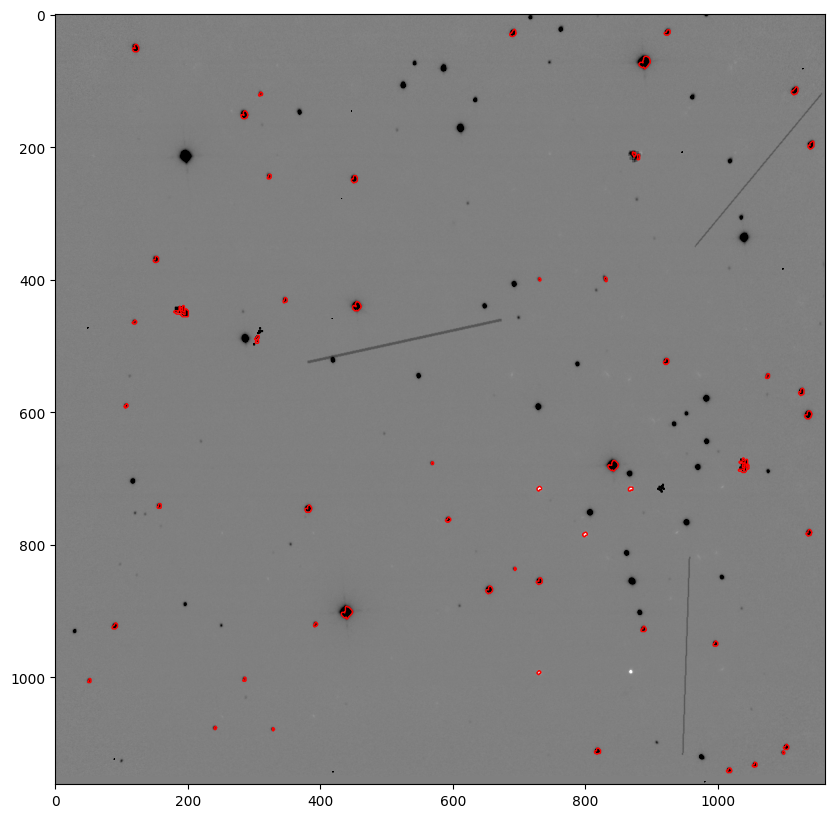

In [104]:
# filtr 



kernel1 = [[-1,0,1],
          [-2,0,2],
          [-1,0,1]]

kernel2 = [[-1,-2,-1],
          [0,0,0],
          [1,2,-1]]

result1 = convolve(image, kernel1)
result2 = convolve(image, kernel2)

maska1 = result1 > np.median(result1) + 500 # + 5 * mad_std(result)
maska2 = result2 > np.median(result2) + 500 # + 5 * mad_std(result)

maska = maska1 | maska2

# znajdowanie grup

conection_kernel = generate_binary_structure(2, 2) # kernel grupowania
labeled_array, num_features = label(maska, structure=conection_kernel)
sizes = ndimage_sum(maska, labeled_array, range(1, num_features + 1))


crays_x = []
crays_y = []

hot_x = []
hot_y = []


maska0 = np.zeros_like(image, dtype=bool)
for i in range(1, num_features + 1):
    tmp = np.argwhere(labeled_array == i)

    if len(tmp) > 5: 
        gx = []
        gy = []
        for ay,ax in tmp:
            gx.append(ax)
            gy.append(ay)
            
            

        gx0 = int(np.mean(gx))
        gy0 = int(np.mean(gy))
        dx = int(max(gx) - min(gx))
        dy = int(max(gy) - min(gy))
        crays_x.append(gx0) 
        crays_y.append(gy0) 

        image_cut = image[gx0-2*dx:gx0+2*dx,gy0-2*dy:gy0+2*dy]

        # Współrzędne pikseli
        y_ind, x_ind = np.indices(image_cut.shape)

        # Spłaszczone dane
        pixels = np.column_stack((y_ind.ravel(), x_ind.ravel()))
        values = image_cut.ravel()

        # Opcjonalna maska, np. tylko jasne piksele
        mask = values > 0
        pixels = pixels[mask]
        values = values[mask]

        mask = values > np.median(values) + mad_std(values)
        pixels = pixels[mask]
        values = values[mask]

        if len(values) > 0:

            # Środek ciężkości (ważony jasnością)
            y_cen = np.average(pixels[:, 0], weights=values)
            x_cen = np.average(pixels[:, 1], weights=values)
    
            # Centrowanie danych względem środka
            centered = pixels - [y_cen, x_cen]
    
            # Macierz kowariancji
            cov = np.cov(centered.T, aweights=values)
            eigvals, eigvecs = np.linalg.eigh(cov)  # [minor, major]
    
            # PCA: główna oś i kąt orientacji
            major_axis = eigvecs[:, 1]
            minor_axis = eigvecs[:, 0]
            ellipticity = eigvals[1] / eigvals[0]  # >1 = wydłużony, ~1 = okrągły
    
    
            print(f"Eliptyczność (major/minor): {ellipticity:.2f}")
    
            print(i,len(tmp))
    
            if ellipticity > 1.5:
                for ay,ax in tmp:
                    maska0[ay,ax] = True



fig, ax = plt.subplots(1, 1, figsize=(10, 10))

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
#ax.plot(crays_x,crays_y,".r")
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska0, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.


plt.show()



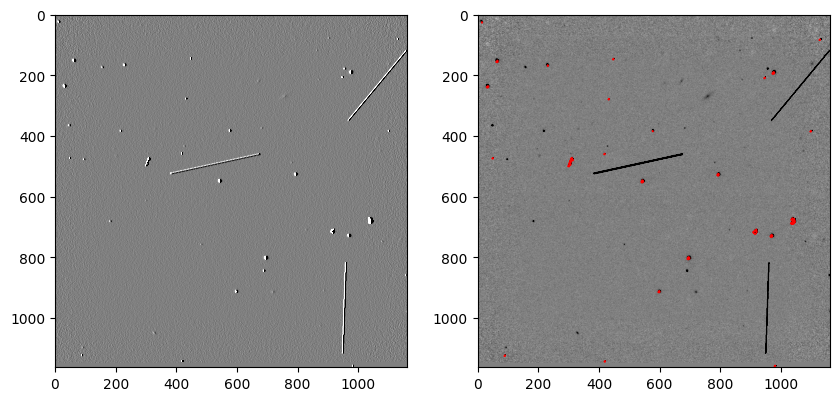

In [28]:
result = result1

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

vmin = np.mean(result) - 1 * np.std(result)
vmax = np.mean(result) + 1 * np.std(result) 
ax[0].imshow(result,vmin=vmin,vmax=vmax,cmap='binary')


vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax[1].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax[1].contour(X, Y, maska, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.


plt.show()